# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to __TensorFlow__ almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [1]:
#XVFB will be launched if you run on a server
import os
if os.environ.get("DISPLAY") is not str or len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
import gym
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline

[2017-08-08 05:55:55,824] Making new env: CartPole-v0


state dim: 4 state: [-0.03117133 -0.02857845 -0.00350353 -0.04090892]
n actions: 2


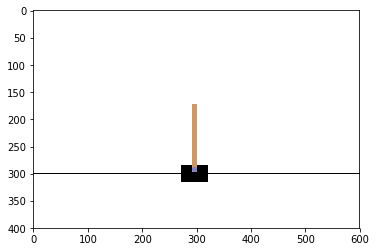

In [3]:
env = gym.make("CartPole-v0")
s = env.reset()
plt.imshow(env.render("rgb_array"))
n_actions = env.action_space.n
state_dim = np.product(env.observation_space.shape)
print('state dim:', state_dim, 'state:', s)
print('n actions:', n_actions)



# Approximate (deep) Q-learning: building the network

In this section we will build and train naive Q-learning with theano/lasagne

First step is initializing input variables

In [4]:
import tensorflow as tf
print(tf.__version__)
assert tf.__version__ > "1.0.0", "try pip install --upgrade tensorflow(-gpu)"
import tensorflow.contrib.layers as tflayers  # Let's make TF simple again

1.1.0


In [5]:
# handle parameters

MEMORY_CAPACITY = 10000
EPSILON = 0.1
GAMMA = 0.9
MINI_BATCH_SIZE = 10

LEARNING_RATE = 0.0001
REGULARIZATION = 0.001
HIDDEN_SIZE = 20

ID = 0
EPISODES = 2000
STEPS = 500
ENVIRONMENT = 'CartPole-v0'

dqn_params = {'memory_capacity': MEMORY_CAPACITY, 
              'epsilon': EPSILON, 
              'gamma': GAMMA, 
              'mini_batch_size': MINI_BATCH_SIZE}

nn_params = {'lr': LEARNING_RATE, 
             'reg': REGULARIZATION,
             'hidden_size': HIDDEN_SIZE}

run_id = '_'.join([str(k) + '_' + str(v) for k, v in dqn_params.items()] + 
                  [str(k) + '_' + str(v) for k, v in nn_params.items()])
print(run_id)

agent_params = {'episodes': EPISODES,
                'steps': STEPS, 
                'environment':ENVIRONMENT, 
                'run_id': run_id}

mini_batch_size_10_memory_capacity_10000_epsilon_0.1_gamma_0.9_lr_0.0001_reg_0.001_hidden_size_20


In [6]:
class NN:
    """
    Neural Network model
    """
    
    def __init__(self, num_actions, state_dim, params={}):
        """
        Initialize the NN model with a set of parameters.
        Args:
            params: a dictionary containing values of the models' parameters.
        """

        self.num_actions = num_actions
        self.state_dim = state_dim

        self.lr = params['lr']
        self.reg = params['reg']
        self.hidden_size = params['hidden_size']
        self.session = self.create_model()


    def add_placeholders(self):
        state_placeholder = tf.placeholder(tf.float32, shape=(None, self.state_dim))
        value_placeholder = tf.placeholder(tf.float32, shape=(None,))
        action_placeholder = tf.placeholder(tf.float32, shape=(None, self.num_actions))

        return state_placeholder, value_placeholder, action_placeholder
    
    def nn(self, state_node):
        with tf.variable_scope("Layer1") as scope:
            W1shape = [self.state_dim, self.hidden_size]
            W1 = tf.get_variable("W1", shape=W1shape,)
            bshape = [1, self.hidden_size]
            b1 = tf.get_variable("b1", shape=bshape, initializer = tf.constant_initializer(0.0))
            scope.reuse_variables()

        with tf.variable_scope("Layer2") as scope:
            W2shape = [self.hidden_size, self.hidden_size]
            W2 = tf.get_variable("W2", shape=W2shape,)
            bshape = [1, self.hidden_size]
            b2 = tf.get_variable("b2", shape=bshape, initializer = tf.constant_initializer(0.0))
            scope.reuse_variables()

        with tf.variable_scope("OutputLayer") as scope:
            Ushape = [self.hidden_size, self.num_actions]
            U = tf.get_variable("U", shape=Ushape)
            b3shape = [1, self.num_actions]
            b3 = tf.get_variable("b3", shape=b3shape, initializer = tf.constant_initializer(0.0))
            scope.reuse_variables()

        xW = tf.matmul(state_node, W1)
        h = tf.tanh(tf.add(xW, b1))

        xW = tf.matmul(h, W2)
        h = tf.tanh(tf.add(xW, b2))

        hU = tf.matmul(h, U)    
        out = tf.add(hU, b3)

        reg = self.reg * (tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(W2)) + tf.reduce_sum(tf.square(U)))
        return out, reg


    def create_model(self):
        """
        The model definition.
        """
        self.state_placeholder, self.value_placeholder, self.action_placeholder = self.add_placeholders()
        outputs, reg = self.nn(self.state_placeholder)
        self.predictions = outputs

        self.q_vals = tf.reduce_sum(tf.multiply(self.predictions, self.action_placeholder), 1)

        self.loss = tf.reduce_sum(tf.square(self.value_placeholder - self.q_vals)) + reg

        optimizer = tf.train.GradientDescentOptimizer(learning_rate = self.lr)

        self.train_op = optimizer.minimize(self.loss)
        init = tf.global_variables_initializer()
        session = tf.Session()
        session.run(init)

        return session

    def train_step(self, Xs, ys, actions):
        """
        Updates the CNN model with a mini batch of training examples.
        """

        loss, _, prediction_probs, q_values = self.session.run(
          [self.loss, self.train_op, self.predictions, self.q_vals],
          feed_dict = {self.state_placeholder: Xs,
                      self.value_placeholder: ys,
                      self.action_placeholder: actions
                      })

    def predict(self, state):
        """
        Predicts the rewards for an input observation state. 
        Args:
        observation: a numpy array of a single observation state
        """

        return self.session.run(self.predictions,
                                feed_dict = {self.state_placeholder: state})

In [7]:
class DQN:

    def __init__(self, num_actions, state_dim, dqn_params, cnn_params):
        self.num_actions = num_actions
        self.epsilon = dqn_params['epsilon']
        self.gamma = dqn_params['gamma']
        self.mini_batch_size = dqn_params['mini_batch_size']

        # memory 
        self.memory = collections.deque(maxlen=dqn_params['memory_capacity'])

        # initialize network
        self.model = NN(num_actions, state_dim, cnn_params)
        print("model initialized")

    def select_action(self, state):
        """
        Selects the next action to take based on the current state and learned Q.
        Args:
          observation: the current state
        """

        if np.random.rand() < self.epsilon:
            # with epsilon probability select a random action
            action = np.random.choice(self.num_actions)
        else:
            # select the action a which maximizes the Q value
            q_values = self.model.predict([state])
            action = np.argmax(q_values)

        return action

    def update_state(self, action, state, new_state, reward, done):
        """
        Stores the most recent action in the replay memory.
        Args: 
          action: the action taken 
          observation: the state before the action was taken
          new_observation: the state after the action is taken
          reward: the reward from the action
          done: a boolean for when the episode has terminated 
        """
        transition = {'action': action,
                      'state': state,
                      'new_state': new_state,
                      'reward': reward,
                      'is_done': done}
        self.memory.append(transition)

    def get_random_mini_batch(self):
        """
        Gets a random sample of transitions from the replay memory.
        """
        rand_idxs = np.random.choice(range(len(self.memory)), self.mini_batch_size)
        mini_batch = []
        for idx in rand_idxs:
          mini_batch.append(self.memory[idx])

        return mini_batch

    def train_step(self):
        """
        Updates the model based on the mini batch
        """
        if len(self.memory) > self.mini_batch_size:
            mini_batch = self.get_random_mini_batch()

            Xs = []
            ys = []
            actions = []

            for sample in mini_batch:
                y_j = sample['reward']

                # for nonterminals, add gamma*max_a(Q(phi_{j+1})) term to y_j
                if not sample['is_done']:
                    new_state = sample['new_state']
                    q_new_values = self.model.predict([new_state])
                    max_action_value = np.max(q_new_values)
                    y_j += self.gamma*max_action_value

                action = np.zeros(self.num_actions)
                action[sample['action']] = 1

                state = sample['state']

                Xs.append(state.copy())
                ys.append(y_j)
                actions.append(action.copy())

            Xs = np.array(Xs)
            ys = np.array(ys)
            actions = np.array(actions)

            self.model.train_step(Xs, ys, actions)

In [8]:
def run_dqn():
    
    env = gym.make(agent_params['environment'])
    episodes = agent_params['episodes']
    steps = agent_params['steps']
    num_actions = env.action_space.n
    state_dim = np.product(env.observation_space.shape)

    # initialize dqn learning
    dqn = DQN(num_actions, state_dim, dqn_params, nn_params)

    last_100 = collections.deque(maxlen=100)

    for i_episode in range(episodes):
        state = env.reset()
        reward_sum = 0

        if np.mean(last_100) > 200:
            break

        for t in range(steps):
            env.render()
            #print observation

            # select action based on the model
            action = dqn.select_action(state)
            # execute actin in emulator
            new_state, reward, done, _ = env.step(action)
            # update the state 
            dqn.update_state(action, state, new_state, reward, done)
            state = new_state

            # train the model
            dqn.train_step()

            reward_sum += reward
            if done:
                print("Episode ", i_episode)
                print("Finished after {} timesteps".format(t+1))
                print("Reward for this episode: ", reward_sum)
                last_100.append(reward_sum)
                print("Average reward for last 100 episodes: ", np.mean(last_100))
                break

    env.monitor.close()

In [9]:
run_dqn()

[2017-08-08 05:55:58,894] Making new env: CartPole-v0
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


model initialized
Episode  0
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  11.0
Episode  1
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  11.0
Episode  2
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.3333333333
Episode  3
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.0
Episode  4
Finished after 8 timesteps
Reward for this episode:  8.0
Average reward for last 100 episodes:  9.6
Episode  5
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  9.5
Episode  6
Finished after 8 timesteps
Reward for this episode:  8.0
Average reward for last 100 episodes:  9.28571428571
Episode  7
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  9.375
Episode  8
Finished after 11 timesteps
Reward for this episode:

Episode  71
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  9.61111111111
Episode  72
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  9.61643835616
Episode  73
Finished after 8 timesteps
Reward for this episode:  8.0
Average reward for last 100 episodes:  9.59459459459
Episode  74
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  9.61333333333
Episode  75
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  9.61842105263
Episode  76
Finished after 14 timesteps
Reward for this episode:  14.0
Average reward for last 100 episodes:  9.67532467532
Episode  77
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  9.69230769231
Episode  78
Finished after 8 timesteps
Reward for this episode:  8.0
Average reward for last 100 episodes:  9.67088607595
Episode  79
Fi

Episode  144
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  9.81
Episode  145
Finished after 13 timesteps
Reward for this episode:  13.0
Average reward for last 100 episodes:  9.85
Episode  146
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  9.88
Episode  147
Finished after 12 timesteps
Reward for this episode:  12.0
Average reward for last 100 episodes:  9.9
Episode  148
Finished after 12 timesteps
Reward for this episode:  12.0
Average reward for last 100 episodes:  9.93
Episode  149
Finished after 12 timesteps
Reward for this episode:  12.0
Average reward for last 100 episodes:  9.97
Episode  150
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  9.97
Episode  151
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  9.99
Episode  152
Finished after 10 timesteps
Reward for this episode:  10.0
A

Average reward for last 100 episodes:  10.04
Episode  216
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.03
Episode  217
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.01
Episode  218
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.0
Episode  219
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.01
Episode  220
Finished after 8 timesteps
Reward for this episode:  8.0
Average reward for last 100 episodes:  9.97
Episode  221
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  9.96
Episode  222
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  9.97
Episode  223
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  9.98
Episode  224
Finished after 10

Episode  289
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.11
Episode  290
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.11
Episode  291
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  10.09
Episode  292
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.11
Episode  293
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.1
Episode  294
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.09
Episode  295
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  10.11
Episode  296
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.13
Episode  297
Finished after 9 timesteps
Reward for this episode:  9.0
Ave

Episode  361
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.33
Episode  362
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.33
Episode  363
Finished after 8 timesteps
Reward for this episode:  8.0
Average reward for last 100 episodes:  10.33
Episode  364
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  10.33
Episode  365
Finished after 12 timesteps
Reward for this episode:  12.0
Average reward for last 100 episodes:  10.35
Episode  366
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.35
Episode  367
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  10.33
Episode  368
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.32
Episode  369
Finished after 10 timesteps
Reward for this episode:  1

Episode  433
Finished after 12 timesteps
Reward for this episode:  12.0
Average reward for last 100 episodes:  10.56
Episode  434
Finished after 9 timesteps
Reward for this episode:  9.0
Average reward for last 100 episodes:  10.54
Episode  435
Finished after 12 timesteps
Reward for this episode:  12.0
Average reward for last 100 episodes:  10.55
Episode  436
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  10.56
Episode  437
Finished after 15 timesteps
Reward for this episode:  15.0
Average reward for last 100 episodes:  10.61
Episode  438
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  10.6
Episode  439
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  10.58
Episode  440
Finished after 12 timesteps
Reward for this episode:  12.0
Average reward for last 100 episodes:  10.59
Episode  441
Finished after 13 timesteps
Reward for this episode:  

Episode  506
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  11.49
Episode  507
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  11.49
Episode  508
Finished after 13 timesteps
Reward for this episode:  13.0
Average reward for last 100 episodes:  11.48
Episode  509
Finished after 10 timesteps
Reward for this episode:  10.0
Average reward for last 100 episodes:  11.49
Episode  510
Finished after 17 timesteps
Reward for this episode:  17.0
Average reward for last 100 episodes:  11.54
Episode  511
Finished after 12 timesteps
Reward for this episode:  12.0
Average reward for last 100 episodes:  11.56
Episode  512
Finished after 11 timesteps
Reward for this episode:  11.0
Average reward for last 100 episodes:  11.58
Episode  513
Finished after 13 timesteps
Reward for this episode:  13.0
Average reward for last 100 episodes:  11.62
Episode  514
Finished after 12 timesteps
Reward for this episode

Episode  577
Finished after 15 timesteps
Reward for this episode:  15.0
Average reward for last 100 episodes:  12.71
Episode  578
Finished after 14 timesteps
Reward for this episode:  14.0
Average reward for last 100 episodes:  12.7
Episode  579
Finished after 17 timesteps
Reward for this episode:  17.0
Average reward for last 100 episodes:  12.76
Episode  580
Finished after 15 timesteps
Reward for this episode:  15.0
Average reward for last 100 episodes:  12.78
Episode  581
Finished after 18 timesteps
Reward for this episode:  18.0
Average reward for last 100 episodes:  12.84
Episode  582
Finished after 13 timesteps
Reward for this episode:  13.0
Average reward for last 100 episodes:  12.82
Episode  583
Finished after 15 timesteps
Reward for this episode:  15.0
Average reward for last 100 episodes:  12.85
Episode  584
Finished after 17 timesteps
Reward for this episode:  17.0
Average reward for last 100 episodes:  12.91
Episode  585
Finished after 17 timesteps
Reward for this episode:

KeyboardInterrupt: 

In [ ]:
class DeepQAgent:

    def __init__(self, n_actions, state_dim, epsilon, alpha, gamma, sess=None):
        self.graph = tf.Graph()
        self.n_actions = n_actions
        self.state_dim = np.product(state_dim)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.h = 10
        
        # construct a network
        with self.graph.as_default():
            self.q_goal = tf.placeholder('float32')
            self.s = tf.placeholder('float32', [self.state_dim])
            self.a = tf.placeholder('uint8')
            a_hot = tf.reshape(tf.one_hot(indices=self.a, depth=n_actions, dtype='float32'), [1, -1])
            
            Ws = self.weight_variable([self.state_dim, self.h])
            Wa = self.weight_variable([n_actions, self.h])
            b = self.bias_variable([self.h])
            
            hidden = tf.sigmoid(tf.matmul(tf.reshape(self.s, [1,-1]), Ws) + 
                                    tf.matmul(a_hot, Wa) + b)
            
            W2 = self.weight_variable([self.h, 1])
            b2 = self.bias_variable([1])
            
            self.score = tf.sigmoid(tf.matmul(hidden, W2) + b2) 
            
            loss = (self.q_goal - self.score)**2
            self.fit = tf.train.AdamOptimizer(learning_rate=self.alpha).minimize(loss)
            self.session = sess or tf.Session()
            self.session.run(tf.global_variables_initializer())
            
            # tensorboard
            writer = tf.summary.FileWriter("/tmp/tboard", graph=tf.get_default_graph())
            writer.close()
    
    def get_Q(self, state, action):
        
        feed = {self.s:state, self.a:action}
        sess = self.session
        q_value = sess.run(self.score, feed_dict=feed)
        return q_value

    def get_Q_state_only(self, state):
        
        return self.get_Q(state, self.get_best_action(state))
        
    def get_best_action(self, state):
        
        q_values = [self.get_Q(state, act) for act in range(n_actions)]
        best = np.argmax(q_values)
        
        return best
        
    def get_action_epsilon_greedy(self, state):
        
        if np.random.rand() < self.epsilon:
            act = np.random.randint(n_actions)
        else:
            act = self.get_best_action(state)
            
        return act
        
    def update(self, s1, a, r, s2):
        
        sess = self.session
        goal = r + self.gamma*self.get_Q_state_only(s2)

        feed = {self.q_goal:goal,
                self.s:s1,
                self.a:a}

        sess.run(self.fit, feed_dict=feed)
            
    @staticmethod    
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.02)
        return tf.Variable(initial)
    
    @staticmethod
    def bias_variable(shape):
        initial = tf.constant(0.05, shape=shape)
        return tf.Variable(initial)
   
        

### Playing the game

In [ ]:
initial_epsilon = 0.5
n_epochs = 1000
alpha = 0.0001
gamma = 0.95

agent = DeepQAgent(n_actions, state_dim, initial_epsilon, alpha, gamma)

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    total_loss = 0
    
    for t in range(t_max):
        
        #get action q-values from the network
        
        a = agent.get_action_epsilon_greedy(s)
        new_s, r, done, info = env.step(a)
        agent.update(s, a, r, new_s)

        total_reward += r
        s = new_s

        if done: break
            
    return total_reward, 0, t

In [ ]:
from tqdm import trange
tr = trange(
    n_epochs,
    desc="mean reward = {:.3f}\tepsilon = {:.3f}\tsteps = {:.3f}".format(0.0, 0.0, 0.0),
    leave=True)


for i in tr:
    
    sessions = [generate_session() for _ in range(100)] #generate new sessions
    session_rewards, _, session_steps = map(np.array, zip(*sessions))
    
    agent.epsilon = max(agent.epsilon*0.99, 0.1)
    
    tr.set_description("mean reward = {:.3f}\tepsilon = {:.3f}\tsteps = {:.3f}".format(
        np.mean(session_rewards), agent.epsilon, np.mean(session_steps)))

    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break
        
    assert initial_epsilon!=0, "Please explore environment"

### Video

In [ ]:
agent.epsilon=0 
#Don't forget to reset epsilon back to initial value if you want to go on training

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",
#run env=gym.make("CartPole-v0");env.reset();

In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

### Homework

Two paths lie ahead of you, and which one to take is a rightfull choice of yours.

* __[recommended]__ Go deeper. Return to seminar1 and get 99% accuracy on MNIST
* __[alternative]__ Try approximate expected-value SARSA and other algorithms and compare it with q-learning 
  * +3 points for EV-SARSA and comparison to Q-learning
  * +2 per additional algorithm
* __[alternative hard]__ Pick ```<your favourite env>``` and solve it, using NN.
 * LunarLander, MountainCar or Breakout (from week1 bonus)
 * LunarLander should get at least +100
 * MountainCar should get at least -200
 * You will need to somehow stabilize learning
   


In [ ]:
np.random.choice(5)

In [ ]:
s = "{'epsilon': 0.1, 'gamma': 0.9, 'mini_batch_size': 10, 'memory_capacity': 10000}{'hidden_size': 20, 'lr': 0.0001, 'reg': 0.001}-id-0"
s.split([':', '"', "'", ','])

In [ ]:
np.array([[1, 2, 3]])